In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# === Base path ===
base_path = "C:/Users/Administrator/PycharmProjects/Comprehensive/Cross_lang_ch8/DARCLnet/"
X_text_edaic = np.load(base_path + "Data_edaic/bert_embeddings_04sec_edaic.npy")
X_audio_edaic = np.load(base_path + "Data_edaic/acoustic_scaled_56_04sec_edaic.npy")
y_edaic = np.load(base_path + "Data_edaic/labels_04sec_edaic.npy")

# === Load MODMA data ===
X_text_modma = np.load(base_path + "Data_modma/bert_embeddings_04sec_modma.npy")
X_audio_modma = np.load(base_path + "Data_modma/acoustic_scaled_56_04sec_modma.npy")
y_modma = np.load(base_path + "Data_modma/labels_04sec_modma.npy")
# === Load CMD-C data ===
X_text_cmdc = np.load(base_path + "Data_cmdc/bert_embeddings_04sec_cmdc.npy")
X_audio_cmdc = np.load(base_path + "Data_cmdc/acoustic_scaled_56_04sec_cmdc.npy")
y_cmdc = np.load(base_path + "Data_cmdc/labels_04sec_cmdc.npy")

# === Load RAVDESS data ===
X_text_ravdess = np.load(base_path + "Data_ravdess/bert_embeddings_04sec_ravdess.npy")
X_audio_ravdess = np.load(base_path + "Data_ravdess/acoustic_scaled_56_04sec_ravdess.npy")
y_ravdess = np.load(base_path + "Data_ravdess/labels_04sec_ravdess.npy")
X_text_rav = X_text_ravdess  # convenient alias

# === Load EATD data ===
X_text_eatd = np.load(base_path + "Data_eatd/bert_embeddings_04sec_eatd.npy")
X_audio_eatd = np.load(base_path + "Data_eatd/acoustic_scaled_56_04sec_eatd.npy")
y_eatd = np.load(base_path + "Data_eatd/labels_04sec_eatd.npy")

# === Fuse and save if needed ===

def fuse_and_save(X_text, X_audio, name_prefix):
    X_fused = np.concatenate([X_text, X_audio], axis=1)
    np.save(base_path + f"X_fused_{name_prefix}.npy", X_fused)
    print(f"✅ Fused features saved as X_fused_{name_prefix}.npy")

# === Fuse EDAIC
fuse_and_save(X_text_edaic, X_audio_edaic, "edaic")

# === Fuse MODMA
fuse_and_save(X_text_modma, X_audio_modma, "modma")

# === Fuse CMD-C
fuse_and_save(X_text_cmdc, X_audio_cmdc, "cmdc")

# === Fuse RAVDESS
fuse_and_save(X_text_ravdess, X_audio_ravdess, "ravdess")

# === Fuse EATD
fuse_and_save(X_text_eatd, X_audio_eatd, "eatd")


✅ Fused features saved as X_fused_edaic.npy
✅ Fused features saved as X_fused_modma.npy
✅ Fused features saved as X_fused_cmdc.npy
✅ Fused features saved as X_fused_ravdess.npy
✅ Fused features saved as X_fused_eatd.npy


In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import joblib

# === Load training data ===
base_path = "C:/Users/Administrator/PycharmProjects/Comprehensive/Cross_lang_ch8/DARCLnet/"

X_eng = np.concatenate([X_text_edaic, X_audio_edaic], axis=1)
X_modma = np.concatenate([X_text_modma, X_audio_modma], axis=1)

y_eng = np.zeros(len(X_eng), dtype=int)   # English = 0
y_modma = np.ones(len(X_modma), dtype=int)  # Chinese = 1

X_train = np.concatenate([X_eng, X_modma], axis=0)
y_train = np.concatenate([y_eng, y_modma], axis=0)

# === Standardize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# === Prepare CMD-C test set ===
X_cmdc = np.concatenate([X_text_cmdc, X_audio_cmdc], axis=1)
y_cmdc = np.ones(len(X_cmdc), dtype=int)  # CMD-C is Chinese
X_cmdc_scaled = scaler.transform(X_cmdc)

# === Prepare RAVDESS test set ===
X_ravdess = np.concatenate([X_text_ravdess, X_audio_ravdess], axis=1)
y_ravdess = np.zeros(len(X_ravdess), dtype=int)  # RAVDESS is English
X_ravdess_scaled = scaler.transform(X_ravdess)

# === Train logistic regression classifier (with enough iterations) ===
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

# === Predict and evaluate on CMD-C ===
y_pred_cmdc = clf.predict(X_cmdc_scaled)
print("\n CMD-C Domain Prediction Report (ML Classifier):")
print(classification_report(
    y_cmdc, y_pred_cmdc,
    labels=[0, 1],
    target_names=["English", "Chinese"],
    digits=4,
    zero_division=0
))
print(f" CMD-C Accuracy: {accuracy_score(y_cmdc, y_pred_cmdc):.4f}")

# === Predict and evaluate on RAVDESS ===
y_pred_ravdess = clf.predict(X_ravdess_scaled)
print("\n RAVDESS Domain Prediction Report (ML Classifier):")
print(classification_report(
    y_ravdess, y_pred_ravdess,
    labels=[0, 1],
    target_names=["English", "Chinese"],
    digits=4,
    zero_division=0
))
print(f" RAVDESS Accuracy: {accuracy_score(y_ravdess, y_pred_ravdess):.4f}")

# === Save model and scaler ===
joblib.dump(clf, base_path + "domain_classifier_logreg.pkl")
joblib.dump(scaler, base_path + "scaler_domain.pkl")



 CMD-C Domain Prediction Report (ML Classifier):
              precision    recall  f1-score   support

     English     0.0000    0.0000    0.0000         0
     Chinese     1.0000    0.9747    0.9872      9116

    accuracy                         0.9747      9116
   macro avg     0.5000    0.4873    0.4936      9116
weighted avg     1.0000    0.9747    0.9872      9116

 CMD-C Accuracy: 0.9747

 RAVDESS Domain Prediction Report (ML Classifier):
              precision    recall  f1-score   support

     English     1.0000    1.0000    1.0000       384
     Chinese     0.0000    0.0000    0.0000         0

    accuracy                         1.0000       384
   macro avg     0.5000    0.5000    0.5000       384
weighted avg     1.0000    1.0000    1.0000       384

 RAVDESS Accuracy: 1.0000


['C:/Users/Administrator/PycharmProjects/Comprehensive/Cross_lang_ch8/DARCLnet/scaler_domain.pkl']

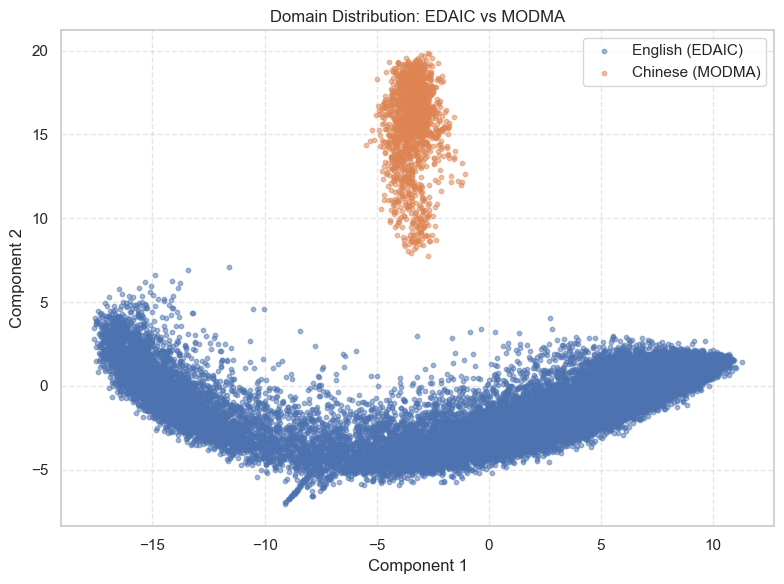

In [18]:
# Class visualization_pcA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load fused features ===
base_path = "C:/Users/Administrator/PycharmProjects/Comprehensive/Cross_lang_ch8/DARCLnet//"


X_eng = np.concatenate([X_text_edaic, X_audio_edaic], axis=1)
X_chi = np.concatenate([X_text_modma, X_audio_modma], axis=1)



# === Create domain labels ===
y_eng = np.zeros(X_eng.shape[0], dtype=int)
y_chi = np.ones(X_chi.shape[0], dtype=int)

# === Combine features and labels ===
X_all = np.concatenate([X_eng, X_chi], axis=0)
y_all = np.concatenate([y_eng, y_chi], axis=0)

# === PCA to 2D ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# === Plot ===
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_all == 0, 0], X_pca[y_all == 0, 1], alpha=0.5, label="English (EDAIC)", s=10)
plt.scatter(X_pca[y_all == 1, 0], X_pca[y_all == 1, 1], alpha=0.5, label="Chinese (MODMA)", s=10)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Domain Distribution: EDAIC vs MODMA")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



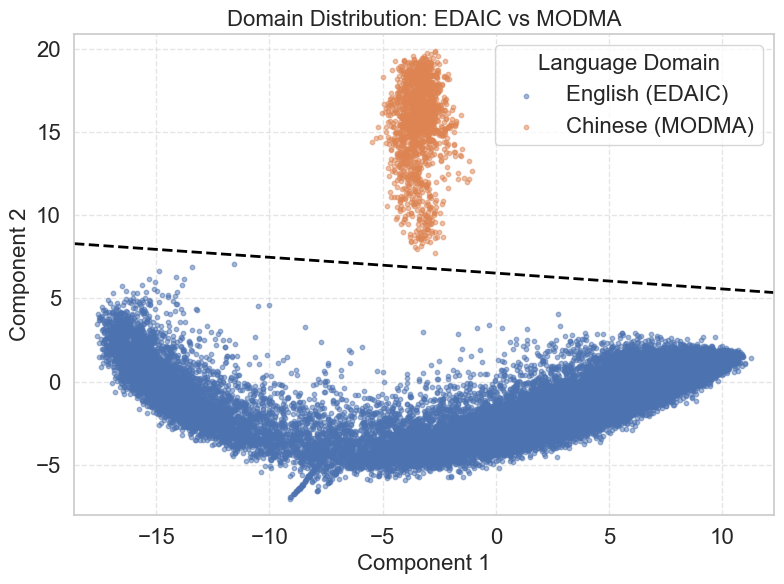

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# === Combine fused features (EDAIC and MODMA only) ===
X_eng = np.concatenate([X_text_edaic, X_audio_edaic], axis=1)
X_chi = np.concatenate([X_text_modma, X_audio_modma], axis=1)

X_all = np.concatenate([X_eng, X_chi], axis=0)
y_all = np.concatenate([
    np.zeros(X_eng.shape[0], dtype=int),   # English (EDAIC)
    np.ones(X_chi.shape[0], dtype=int)     # Chinese (MODMA)
])

# === PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# === Logistic Regression
lr = LogisticRegression()
lr.fit(X_pca, y_all)

# === Decision boundary mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = lr.predict_proba(grid)[:, 1].reshape(xx.shape)

# === Plot
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyles='--')

plt.scatter(X_pca[y_all == 0, 0], X_pca[y_all == 0, 1], alpha=0.5, label="English (EDAIC)", s=10)
plt.scatter(X_pca[y_all == 1, 0], X_pca[y_all == 1, 1], alpha=0.5, label="Chinese (MODMA)", s=10)

plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.title("Domain Distribution: EDAIC vs MODMA", fontsize=16)
plt.legend(fontsize=16, title="Language Domain", title_fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


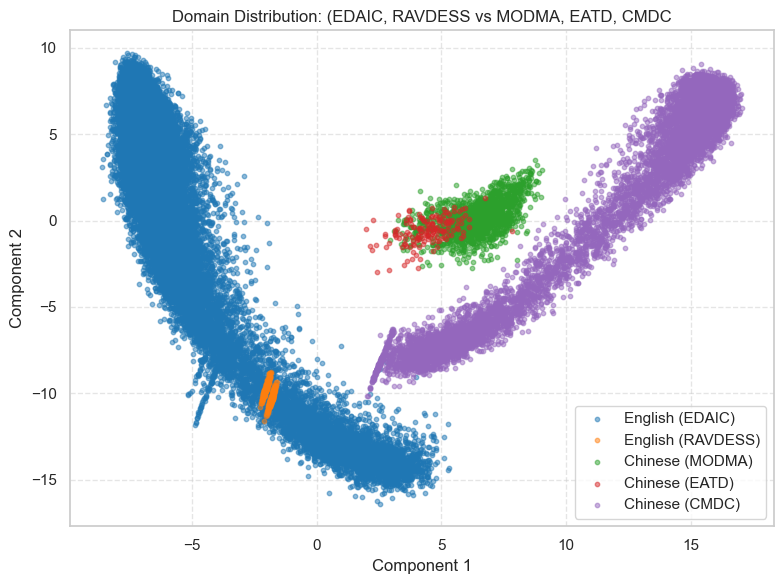

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Combine fused features ===
X_eng_edaic = np.concatenate([X_text_edaic, X_audio_edaic], axis=1)
X_eng_rav = np.concatenate([X_text_ravdess, X_audio_ravdess], axis=1)
X_chi_modma = np.concatenate([X_text_modma, X_audio_modma], axis=1)
X_chi_eatd = np.concatenate([X_text_eatd, X_audio_eatd], axis=1)
X_chi_cmdc = np.concatenate([X_text_cmdc, X_audio_cmdc], axis=1)

# === Create dataset labels ===
y_eng_edaic = np.full(X_eng_edaic.shape[0], 0, dtype=int)   # 0 = English (EDAIC)
y_eng_rav = np.full(X_eng_rav.shape[0], 1, dtype=int)       # 1 = English (RAVDESS)
y_chi_modma = np.full(X_chi_modma.shape[0], 2, dtype=int)   # 2 = Chinese (MODMA)
y_chi_eatd = np.full(X_chi_eatd.shape[0], 3, dtype=int)     # 3 = Chinese (EATD)
y_chi_cmdc = np.full(X_chi_cmdc.shape[0], 4, dtype=int)     # 4 = Chinese (CMD-C)

# === Combine features and labels ===
X_all = np.concatenate([X_eng_edaic, X_eng_rav, X_chi_modma, X_chi_eatd, X_chi_cmdc], axis=0)
y_all = np.concatenate([y_eng_edaic, y_eng_rav, y_chi_modma, y_chi_eatd, y_chi_cmdc], axis=0)

# === PCA to 2D ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# === Dataset info ===
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels = ["English (EDAIC)", "English (RAVDESS)", "Chinese (MODMA)", "Chinese (EATD)", "Chinese (CMDC)"]

# === Plot with consistent colors ===
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.scatter(X_pca[y_all == i, 0], X_pca[y_all == i, 1],
                alpha=0.5, s=10, color=colors[i], label=labels[i])

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Domain Distribution: (EDAIC, RAVDESS vs MODMA, EATD, CMDC")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


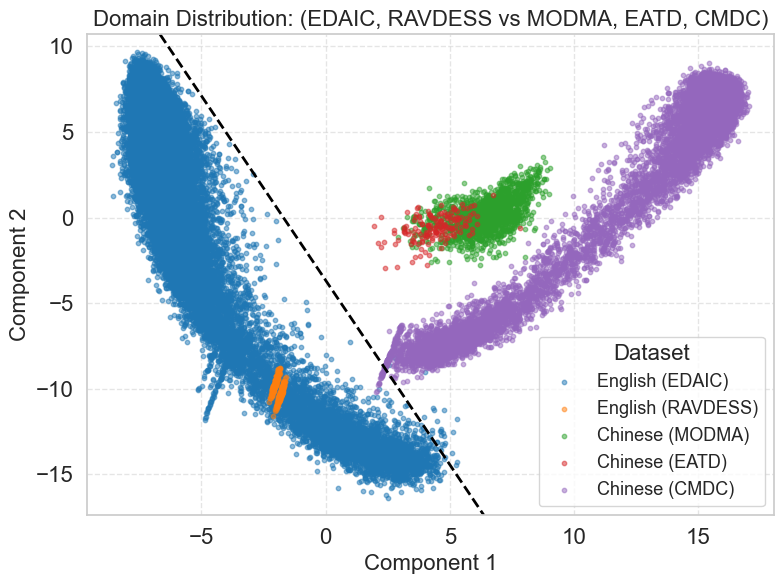

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# === Combine fused features
X_eng_edaic = np.concatenate([X_text_edaic, X_audio_edaic], axis=1)
X_eng_rav = np.concatenate([X_text_ravdess, X_audio_ravdess], axis=1)
X_chi_modma = np.concatenate([X_text_modma, X_audio_modma], axis=1)
X_chi_eatd = np.concatenate([X_text_eatd, X_audio_eatd], axis=1)
X_chi_cmdc = np.concatenate([X_text_cmdc, X_audio_cmdc], axis=1)

# === Dataset and Domain Labels
X_all = np.concatenate([X_eng_edaic, X_eng_rav, X_chi_modma, X_chi_eatd, X_chi_cmdc], axis=0)
y_dataset = np.concatenate([
    np.full(X_eng_edaic.shape[0], 0),
    np.full(X_eng_rav.shape[0], 1),
    np.full(X_chi_modma.shape[0], 2),
    np.full(X_chi_eatd.shape[0], 3),
    np.full(X_chi_cmdc.shape[0], 4)
])
y_binary = np.concatenate([
    np.zeros(X_eng_edaic.shape[0] + X_eng_rav.shape[0], dtype=int),  # English
    np.ones(X_chi_modma.shape[0] + X_chi_eatd.shape[0] + X_chi_cmdc.shape[0], dtype=int)  # Chinese
])

# === PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# === Logistic Regression on PCA space
lr = LogisticRegression()
lr.fit(X_pca, y_binary)

# === Decision boundary grid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = lr.predict_proba(grid)[:, 1].reshape(xx.shape)

# === Plot
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyles='--')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels = ['English (EDAIC)', 'English (RAVDESS)', 'Chinese (MODMA)', 'Chinese (EATD)', 'Chinese (CMDC)']

for i in range(5):
    plt.scatter(X_pca[y_dataset == i, 0], X_pca[y_dataset == i, 1],
                alpha=0.5, label=labels[i], color=colors[i], s=10)

plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.title("Domain Distribution: (EDAIC, RAVDESS vs MODMA, EATD, CMDC)", fontsize=16)
plt.legend(fontsize=13, title="Dataset", title_fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [22]:
print(lr.get_params())
print(lr.solver)


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
lbfgs



=== Run 1/30 ===

=== Run 2/30 ===

=== Run 3/30 ===

=== Run 4/30 ===

=== Run 5/30 ===

=== Run 6/30 ===

=== Run 7/30 ===

=== Run 8/30 ===

=== Run 9/30 ===

=== Run 10/30 ===

=== Run 11/30 ===

=== Run 12/30 ===

=== Run 13/30 ===

=== Run 14/30 ===

=== Run 15/30 ===

=== Run 16/30 ===

=== Run 17/30 ===

=== Run 18/30 ===

=== Run 19/30 ===

=== Run 20/30 ===

=== Run 21/30 ===

=== Run 22/30 ===

=== Run 23/30 ===

=== Run 24/30 ===

=== Run 25/30 ===

=== Run 26/30 ===

=== Run 27/30 ===

=== Run 28/30 ===

=== Run 29/30 ===

=== Run 30/30 ===

📋 Averaged Classification Report for Mixed Test Set
Class          Precision    Recall  F1-Score
----------------------------------------------
HC             94.85     97.24     96.03
MDD            93.01     87.38     90.09

Accuracy       94.33
Macro Avg      93.93     92.31     93.06
Weighted Avg   94.31     94.33     94.28


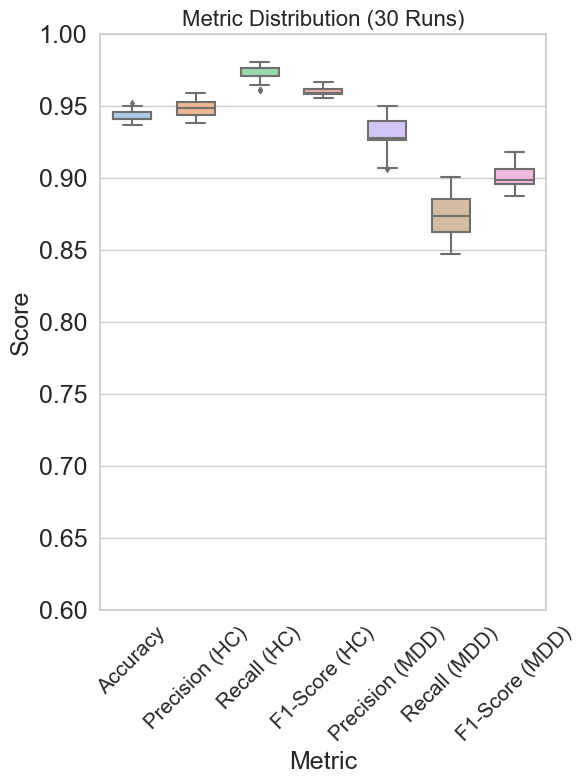

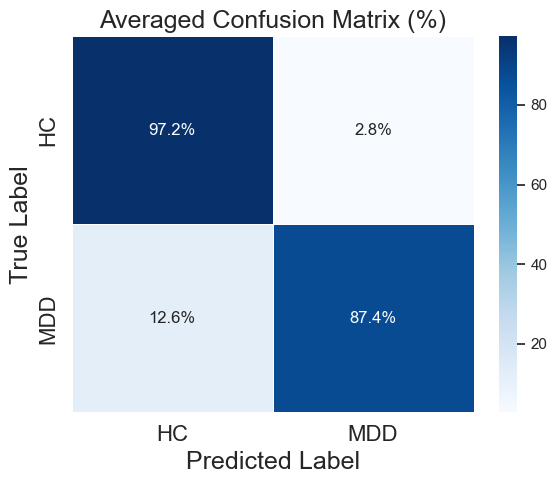

In [8]:
# === Domain-Aware Model Evaluation on EDAIC and MODMA ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# === Plotting Style ===
sns.set(style="whitegrid")

# === Base Path ===
base_path = "C:/Users/Administrator/PycharmProjects/Comprehensive/Cross_lang_ch8/DARCLnet/"

# === Load Domain Classifier and Scaler ===
domain_clf = joblib.load(base_path + "domain_classifier_logreg.pkl")
scaler_domain = joblib.load(base_path + "scaler_domain.pkl")

# === Load Embeddings and Labels ===
X_text_edaic = np.load(base_path + "Data_edaic/bert_embeddings_04sec_edaic.npy")
X_audio_edaic = np.load(base_path + "Data_edaic/acoustic_scaled_56_04sec_edaic.npy")
y_edaic = np.load(base_path + "Data_edaic/labels_04sec_edaic.npy")

X_text_modma = np.load(base_path + "Data_modma/bert_embeddings_04sec_modma.npy")
X_audio_modma = np.load(base_path + "Data_modma/acoustic_scaled_56_04sec_modma.npy")
y_modma = np.load(base_path + "Data_modma/labels_04sec_modma.npy")

# === Subsample ===
X_fused_edaic = np.concatenate([X_text_edaic, X_audio_edaic], axis=1)[::81]
y_edaic = y_edaic[::81]

X_fused_modma = np.concatenate([X_text_modma, X_audio_modma], axis=1)[::10]
y_modma = y_modma[::10]

# === Combine for Evaluation ===
X_mixed = np.concatenate([X_fused_edaic, X_fused_modma], axis=0)
y_mixed = np.concatenate([y_edaic, y_modma], axis=0)

n_runs = 30
results = []
conf_matrices = []

for run in range(n_runs):
    print(f"\n=== Run {run + 1}/{n_runs} ===")

    # === English Branch ===
    X_train_en, X_val_en, y_train_en, y_val_en = train_test_split(X_fused_edaic, y_edaic, test_size=0.1, stratify=y_edaic)
    scaler_en = StandardScaler()
    X_train_en = scaler_en.fit_transform(X_train_en)
    X_val_en = scaler_en.transform(X_val_en)

    model_en = Sequential([
        Input(shape=(X_fused_edaic.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model_en.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model_en.fit(X_train_en, y_train_en, validation_data=(X_val_en, y_val_en), batch_size=64, epochs=10, verbose=0)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, X_fused_edaic.shape[1]], dtype=tf.float32)])
    def predict_en_fixed(X):
        return model_en(X, training=False)

    # === Chinese Branch ===
    X_train_ch, X_val_ch, y_train_ch, y_val_ch = train_test_split(X_fused_modma, y_modma, test_size=0.1, stratify=y_modma)
    scaler_ch = StandardScaler()
    X_train_ch = scaler_ch.fit_transform(X_train_ch)
    X_val_ch = scaler_ch.transform(X_val_ch)

    model_ch = Sequential([
        Input(shape=(X_fused_modma.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model_ch.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model_ch.fit(X_train_ch, y_train_ch, validation_data=(X_val_ch, y_val_ch), batch_size=64, epochs=10, verbose=0)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, X_fused_modma.shape[1]], dtype=tf.float32)])
    def predict_ch_fixed(X):
        return model_ch(X, training=False)

    # === Domain Routing Inference ===
    X_domain = scaler_domain.transform(X_mixed)
    domain_preds = domain_clf.predict(X_domain)
    y_pred = np.zeros_like(y_mixed)

    if np.any(domain_preds == 1):
        X_ch = scaler_ch.transform(X_mixed[domain_preds == 1])
        X_ch_tensor = tf.convert_to_tensor(X_ch, dtype=tf.float32)
        y_pred_ch = (predict_ch_fixed(X_ch_tensor).numpy().flatten() > 0.5).astype(int)
        y_pred[domain_preds == 1] = y_pred_ch

    if np.any(domain_preds == 0):
        X_en = scaler_en.transform(X_mixed[domain_preds == 0])
        X_en_tensor = tf.convert_to_tensor(X_en, dtype=tf.float32)
        y_pred_en = (predict_en_fixed(X_en_tensor).numpy().flatten() > 0.5).astype(int)
        y_pred[domain_preds == 0] = y_pred_en

    acc = accuracy_score(y_mixed, y_pred)
    report = classification_report(y_mixed, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_mixed, y_pred, labels=[0, 1])
    conf_matrices.append(cm)

    results.append({
        "Run": run + 1,
        "Accuracy": acc,
        "Precision_HC": report["0"]["precision"],
        "Recall_HC": report["0"]["recall"],
        "F1_HC": report["0"]["f1-score"],
        "Precision_MDD": report["1"]["precision"],
        "Recall_MDD": report["1"]["recall"],
        "F1_MDD": report["1"]["f1-score"]
    })

# === Save Results ===
results_df = pd.DataFrame(results)
results_df.to_csv(base_path + "domain_aware_eval_results.csv", index=False)
np.save(base_path + "domain_aware_conf_matrices.npy", np.array(conf_matrices))

# === Summary Stats ===
avg = results_df.mean(numeric_only=True)
prec_hc, rec_hc, f1_hc = avg["Precision_HC"] * 100, avg["Recall_HC"] * 100, avg["F1_HC"] * 100
prec_mdd, rec_mdd, f1_mdd = avg["Precision_MDD"] * 100, avg["Recall_MDD"] * 100, avg["F1_MDD"] * 100
acc = avg["Accuracy"] * 100

macro_prec = (prec_hc + prec_mdd) / 2
macro_rec = (rec_hc + rec_mdd) / 2
macro_f1 = (f1_hc + f1_mdd) / 2

pos_ratio = y_mixed.mean()
neg_ratio = 1 - pos_ratio
weighted_prec = (prec_hc * neg_ratio) + (prec_mdd * pos_ratio)
weighted_rec = (rec_hc * neg_ratio) + (rec_mdd * pos_ratio)
weighted_f1 = (f1_hc * neg_ratio) + (f1_mdd * pos_ratio)

print("\n📋 Averaged Classification Report for Mixed Test Set")
print("Class          Precision    Recall  F1-Score")
print("----------------------------------------------")
print(f"HC             {prec_hc:.2f}     {rec_hc:.2f}     {f1_hc:.2f}")
print(f"MDD            {prec_mdd:.2f}     {rec_mdd:.2f}     {f1_mdd:.2f}")
print(f"\nAccuracy       {acc:.2f}")
print(f"Macro Avg      {macro_prec:.2f}     {macro_rec:.2f}     {macro_f1:.2f}")
print(f"Weighted Avg   {weighted_prec:.2f}     {weighted_rec:.2f}     {weighted_f1:.2f}")

# === Boxplot ===
metrics_order = [
    ("Accuracy", "Accuracy"),
    ("Precision_HC", "Precision (HC)"),
    ("Recall_HC", "Recall (HC)"),
    ("F1_HC", "F1-Score (HC)"),
    ("Precision_MDD", "Precision (MDD)"),
    ("Recall_MDD", "Recall (MDD)"),
    ("F1_MDD", "F1-Score (MDD)")
]

data = []
labels = []
for metric_key, metric_label in metrics_order:
    data.extend(results_df[metric_key])
    labels.extend([metric_label] * len(results_df[metric_key]))

df_plot = pd.DataFrame({"Metric": labels, "Value": data})

plt.figure(figsize=(6, 8))
sns.boxplot(x="Metric", y="Value", data=df_plot, palette="pastel", width=0.6, fliersize=3)
plt.title("Metric Distribution (30 Runs)", fontsize=16)
plt.ylabel("Score", fontsize=18)
plt.xlabel("Metric", fontsize=18)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=18)
plt.ylim(0.6, 1.0)
plt.tight_layout()
plt.savefig(base_path + "boxplot_domain_aware.png")
plt.show()

# === Confusion Matrix ===
cm_total = np.sum(conf_matrices, axis=0)
cm_normalized = cm_total.astype('float') / cm_total.sum(axis=1)[:, np.newaxis] * 100
labels_cm = np.array([["{0:.1f}%".format(value) for value in row] for row in cm_normalized])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=labels_cm, fmt="", cmap="Blues",
            linewidths=0.5, linecolor="white",
            xticklabels=["HC", "MDD"], yticklabels=["HC", "MDD"], cbar=True)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.title("Averaged Confusion Matrix (%)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(base_path + "conf_matrix_domain_aware.png")
plt.show()



=== Run 1/30 ===

=== Run 2/30 ===

=== Run 3/30 ===

=== Run 4/30 ===

=== Run 5/30 ===

=== Run 6/30 ===

=== Run 7/30 ===

=== Run 8/30 ===

=== Run 9/30 ===

=== Run 10/30 ===

=== Run 11/30 ===

=== Run 12/30 ===

=== Run 13/30 ===

=== Run 14/30 ===

=== Run 15/30 ===

=== Run 16/30 ===

=== Run 17/30 ===

=== Run 18/30 ===

=== Run 19/30 ===

=== Run 20/30 ===

=== Run 21/30 ===

=== Run 22/30 ===

=== Run 23/30 ===

=== Run 24/30 ===

=== Run 25/30 ===

=== Run 26/30 ===

=== Run 27/30 ===

=== Run 28/30 ===

=== Run 29/30 ===

=== Run 30/30 ===

 Averaged Classification Report for CMDC (Test Set)
Class          Precision    Recall  F1-Score
----------------------------------------------
HC             85.25     61.50     68.84
MDD            57.15     80.39     64.60

Accuracy       68.03
Macro Avg      71.20     70.95     66.72
Weighted Avg   75.54     68.03     67.38


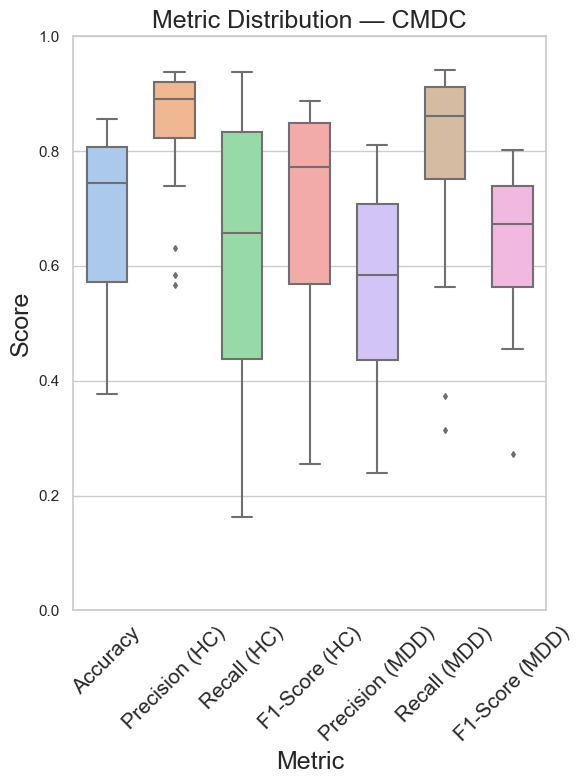

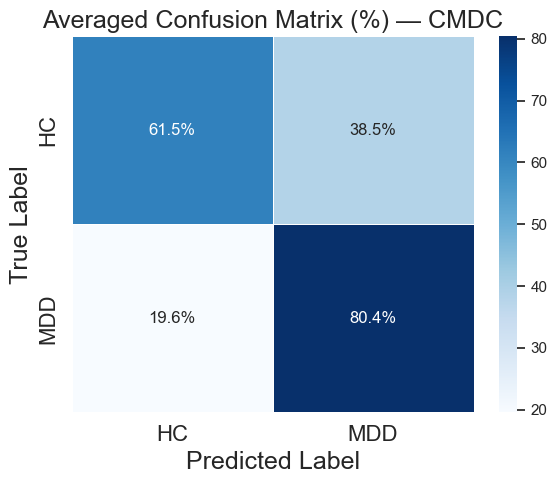


 Averaged Classification Report for RAVDESS (Test Set)
Class          Precision    Recall  F1-Score
----------------------------------------------
HC             61.21     28.11     34.46
MDD            52.92     79.50     62.37

Accuracy       53.80
Macro Avg      57.07     53.80     48.41
Weighted Avg   57.07     53.80     48.41


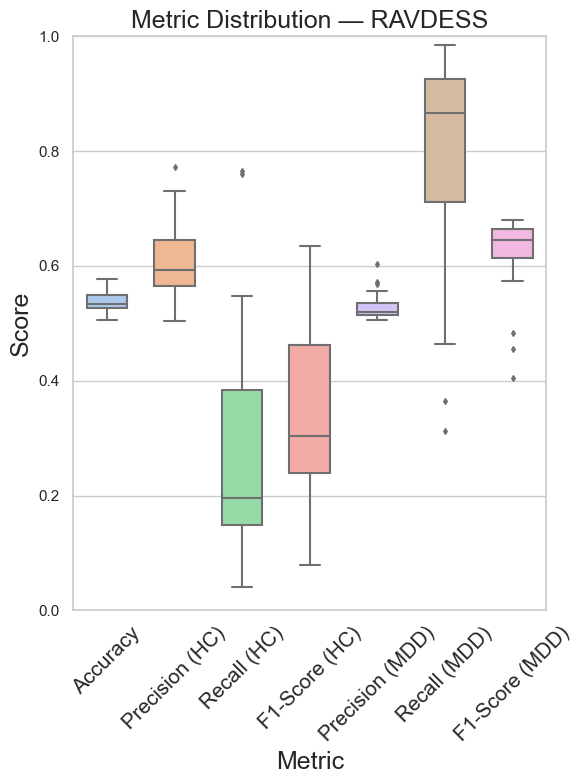

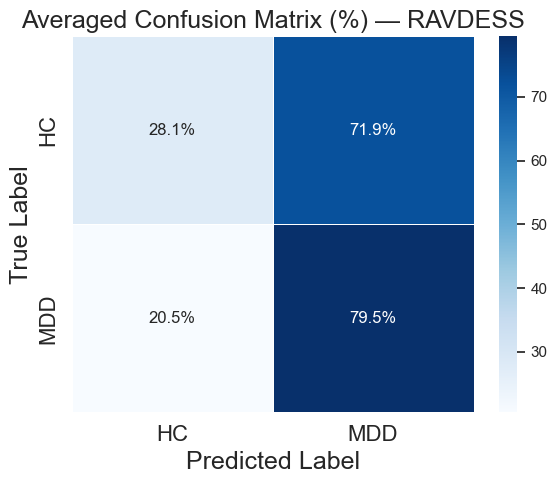


 Averaged Classification Report for EATD (Test Set)
Class          Precision    Recall  F1-Score
----------------------------------------------
HC             84.67     60.25     67.58
MDD            28.69     56.56     35.53

Accuracy       59.57
Macro Avg      56.68     58.41     51.56
Weighted Avg   74.24     59.57     61.61


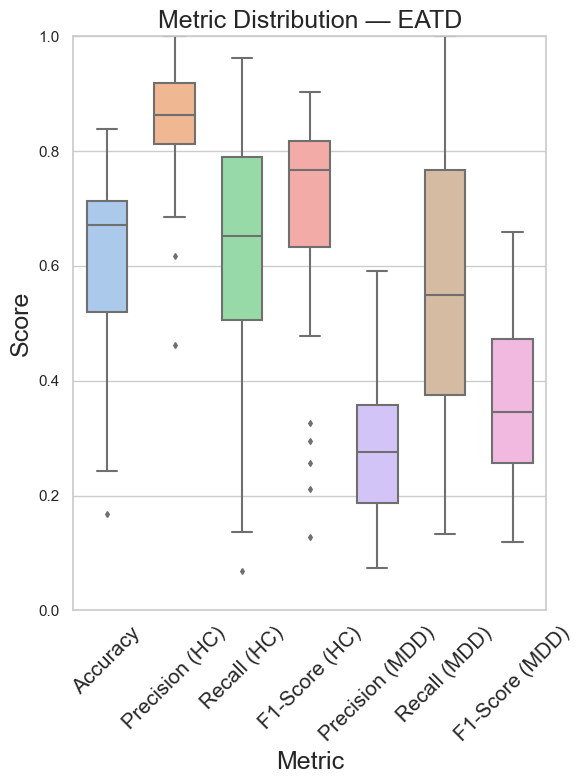

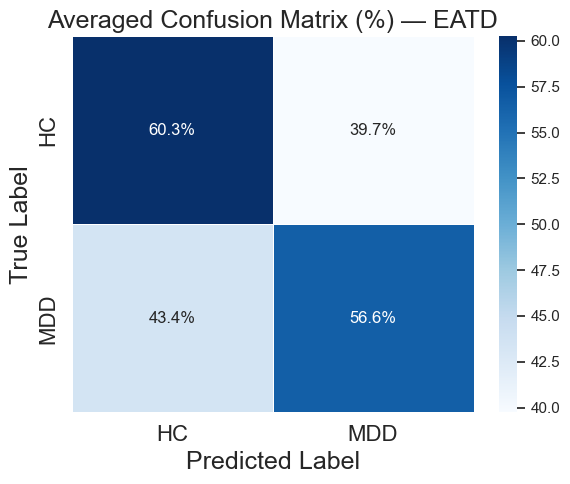

In [10]:
# === # Domain-aware model on unseen datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import os

sns.set(style="whitegrid")

# === Base Path ===
base_path = "C:/Users/Administrator/PycharmProjects/Comprehensive/Cross_lang_ch8/DARCLnet/"

# === Load Domain Classifier and Scaler
domain_clf = joblib.load(base_path + "domain_classifier_logreg.pkl")
scaler_domain = joblib.load(base_path + "scaler_domain.pkl")

# === Load Datasets
X_cmdc = np.load(base_path + "X_fused_cmdc.npy")
y_cmdc = np.load(base_path + "Data_cmdc/labels_04sec_cmdc.npy")

X_ravdess = np.load(base_path + "X_fused_ravdess.npy")
y_ravdess = np.load(base_path + "Data_ravdess/labels_04sec_ravdess.npy")

X_eatd = np.load(base_path + "Data_eatd/combined_embeddings_04sec_eatd.npy")
y_eatd = np.load(base_path + "Data_eatd/labels_04sec_eatd.npy")

X_edaic = np.load(base_path + "X_fused_edaic.npy")
y_edaic = np.load(base_path + "Data_edaic/labels_04sec_edaic.npy")

X_modma = np.load(base_path + "X_fused_modma.npy")
y_modma = np.load(base_path + "Data_modma/labels_04sec_modma.npy")

datasets = {
    "CMDC": (X_cmdc, y_cmdc),
    "RAVDESS": (X_ravdess, y_ravdess),
    "EATD": (X_eatd, y_eatd)
}

# === Initialize
n_runs = 30
results = {
    dataset: {
        "Accuracy": [],
        "Precision_HC": [], "Recall_HC": [], "F1_HC": [],
        "Precision_MDD": [], "Recall_MDD": [], "F1_MDD": []
    }
    for dataset in datasets
}
conf_matrices = {dataset: [] for dataset in datasets}

# === Training + Evaluation Loop
for run in range(n_runs):
    print(f"\n=== Run {run+1}/{n_runs} ===")

    # Train English Branch
    X_train_en, X_val_en, y_train_en, y_val_en = train_test_split(X_edaic, y_edaic, test_size=0.1, stratify=y_edaic)
    scaler_en = StandardScaler()
    X_train_en = scaler_en.fit_transform(X_train_en)
    X_val_en = scaler_en.transform(X_val_en)

    model_en = Sequential([
        Input(shape=(X_edaic.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model_en.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model_en.fit(X_train_en, y_train_en, validation_data=(X_val_en, y_val_en), batch_size=64, epochs=10, verbose=0)

    # Train Chinese Branch
    X_train_ch, X_val_ch, y_train_ch, y_val_ch = train_test_split(X_modma, y_modma, test_size=0.1, stratify=y_modma)
    scaler_ch = StandardScaler()
    X_train_ch = scaler_ch.fit_transform(X_train_ch)
    X_val_ch = scaler_ch.transform(X_val_ch)

    model_ch = Sequential([
        Input(shape=(X_modma.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model_ch.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model_ch.fit(X_train_ch, y_train_ch, validation_data=(X_val_ch, y_val_ch), batch_size=64, epochs=10, verbose=0)

    # Evaluate on Unseen Datasets
    for dataset_name, (X_test_raw, y_test) in datasets.items():
        X_domain = scaler_domain.transform(X_test_raw)
        domain_preds = domain_clf.predict(X_domain)

        y_pred = np.zeros_like(y_test)

        if np.any(domain_preds == 1):
            X_ch = scaler_ch.transform(X_test_raw[domain_preds == 1])
            y_pred_ch = (model_ch.predict(X_ch, verbose=0).flatten() > 0.5).astype(int)
            y_pred[domain_preds == 1] = y_pred_ch

        if np.any(domain_preds == 0):
            X_en = scaler_en.transform(X_test_raw[domain_preds == 0])
            y_pred_en = (model_en.predict(X_en, verbose=0).flatten() > 0.5).astype(int)
            y_pred[domain_preds == 0] = y_pred_en

        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        results[dataset_name]["Accuracy"].append(acc)
        results[dataset_name]["Precision_HC"].append(report["0"]["precision"])
        results[dataset_name]["Recall_HC"].append(report["0"]["recall"])
        results[dataset_name]["F1_HC"].append(report["0"]["f1-score"])
        results[dataset_name]["Precision_MDD"].append(report["1"]["precision"])
        results[dataset_name]["Recall_MDD"].append(report["1"]["recall"])
        results[dataset_name]["F1_MDD"].append(report["1"]["f1-score"])

        conf_matrices[dataset_name].append(cm)

# === Reporting & Saving
for dataset_name in datasets.keys():
    df = pd.DataFrame(results[dataset_name])
    df.to_csv(base_path + f"{dataset_name.lower()}_branch_20runs_domain_blind_unseen _data.csv", index=False)

    print(f"\n Averaged Classification Report for {dataset_name} (Test Set)")
    prec_hc = df["Precision_HC"].mean() * 100
    rec_hc = df["Recall_HC"].mean() * 100
    f1_hc = df["F1_HC"].mean() * 100
    prec_mdd = df["Precision_MDD"].mean() * 100
    rec_mdd = df["Recall_MDD"].mean() * 100
    f1_mdd = df["F1_MDD"].mean() * 100
    acc = df["Accuracy"].mean() * 100

    macro_prec = (prec_hc + prec_mdd) / 2
    macro_rec = (rec_hc + rec_mdd) / 2
    macro_f1 = (f1_hc + f1_mdd) / 2

    pos_ratio = datasets[dataset_name][1].mean()
    neg_ratio = 1 - pos_ratio
    weighted_prec = (prec_hc * neg_ratio) + (prec_mdd * pos_ratio)
    weighted_rec = (rec_hc * neg_ratio) + (rec_mdd * pos_ratio)
    weighted_f1 = (f1_hc * neg_ratio) + (f1_mdd * pos_ratio)

    print("Class          Precision    Recall  F1-Score")
    print("----------------------------------------------")
    print(f"HC             {prec_hc:.2f}     {rec_hc:.2f}     {f1_hc:.2f}")
    print(f"MDD            {prec_mdd:.2f}     {rec_mdd:.2f}     {f1_mdd:.2f}")
    print(f"\nAccuracy       {acc:.2f}")
    print(f"Macro Avg      {macro_prec:.2f}     {macro_rec:.2f}     {macro_f1:.2f}")
    print(f"Weighted Avg   {weighted_prec:.2f}     {weighted_rec:.2f}     {weighted_f1:.2f}")

    # Save Boxplot
    plt.figure(figsize=(6,8))
    data = []
    labels = []
    for key, label in [
        ("Accuracy", "Accuracy"),
        ("Precision_HC", "Precision (HC)"),
        ("Recall_HC", "Recall (HC)"),
        ("F1_HC", "F1-Score (HC)"),
        ("Precision_MDD", "Precision (MDD)"),
        ("Recall_MDD", "Recall (MDD)"),
        ("F1_MDD", "F1-Score (MDD)")
    ]:
        data.extend(results[dataset_name][key])
        labels.extend([label] * n_runs)

    df_plot = pd.DataFrame({ "Metric": labels, "Value": data })
    sns.boxplot(x="Metric", y="Value", data=df_plot, palette="pastel", width=0.6, fliersize=3)
    plt.title(f"Metric Distribution — {dataset_name}", fontsize=18)
    plt.ylabel("Score", fontsize=18)
    plt.xlabel("Metric", fontsize=18)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=11)
    plt.ylim(0.0, 1.0)
    plt.tight_layout()
    plt.savefig(base_path + f"{dataset_name.lower()}_boxplot.png")
    plt.show()

    # Save Confusion Matrix
    cm_total = np.sum(conf_matrices[dataset_name], axis=0)
    cm_normalized = cm_total.astype('float') / cm_total.sum(axis=1)[:, np.newaxis] * 100
    labels_cm = np.array([["{0:.1f}%".format(value) for value in row] for row in cm_normalized])

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_normalized, annot=labels_cm, fmt="", cmap="Blues",
        linewidths=0.5, linecolor="white",
        xticklabels=["HC", "MDD"], yticklabels=["HC", "MDD"],
        cbar=True
    )
    plt.xlabel("Predicted Label", fontsize=18)
    plt.ylabel("True Label", fontsize=18)
    plt.title(f"Averaged Confusion Matrix (%) — {dataset_name}", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(base_path + f"{dataset_name.lower()}_confusion_matrix.png")
    plt.show()



=== Run 1/30 ===

=== Run 2/30 ===

=== Run 3/30 ===

=== Run 4/30 ===

=== Run 5/30 ===

=== Run 6/30 ===

=== Run 7/30 ===

=== Run 8/30 ===

=== Run 9/30 ===

=== Run 10/30 ===

=== Run 11/30 ===

=== Run 12/30 ===

=== Run 13/30 ===

=== Run 14/30 ===

=== Run 15/30 ===

=== Run 16/30 ===

=== Run 17/30 ===

=== Run 18/30 ===

=== Run 19/30 ===

=== Run 20/30 ===

=== Run 21/30 ===

=== Run 22/30 ===

=== Run 23/30 ===

=== Run 24/30 ===

=== Run 25/30 ===

=== Run 26/30 ===

=== Run 27/30 ===

=== Run 28/30 ===

=== Run 29/30 ===

=== Run 30/30 ===

=== Classification Report on Mixed Unseen Set ===
              precision    recall  f1-score   support

          HC     0.9300    0.7456    0.8277      6290
         MDD     0.6535    0.8953    0.7555      3371

    accuracy                         0.7978      9661
   macro avg     0.7918    0.8205    0.7916      9661
weighted avg     0.8335    0.7978    0.8025      9661



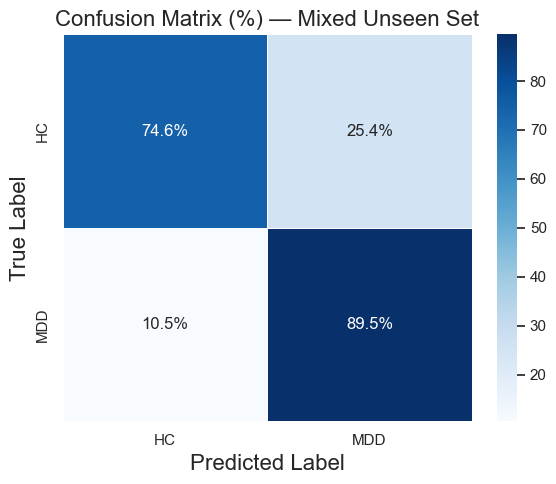

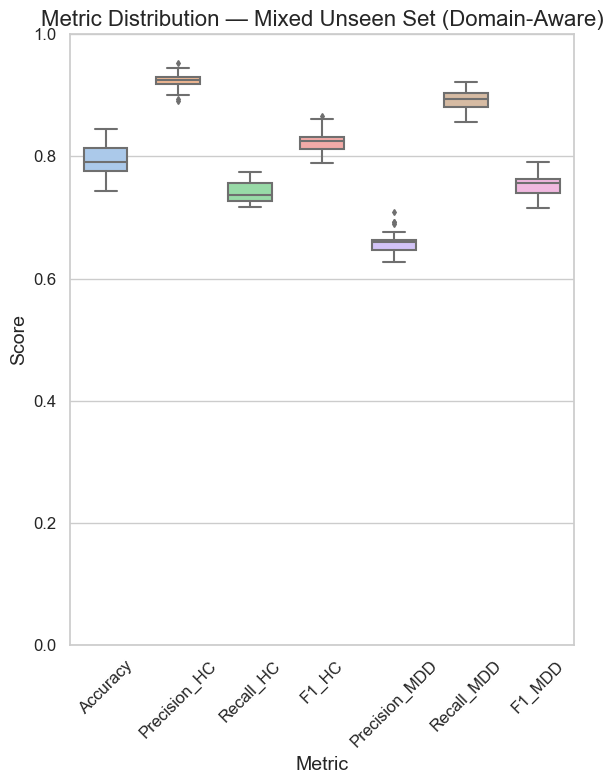

In [26]:
#tests on the mixed datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

sns.set(style="whitegrid")

# === Base Path ===
base_path = "C:/Users/Administrator/PycharmProjects/Comprehensive/Cross_lang_ch8/DARCLnet/"

# === Load Domain Classifier and Scaler
domain_clf = joblib.load(base_path + "domain_classifier_logreg.pkl")
scaler_domain = joblib.load(base_path + "scaler_domain.pkl")

# === Load Training Datasets
X_edaic = np.load(base_path + "X_fused_edaic.npy")
y_edaic = np.load(base_path + "Data_edaic/labels_04sec_edaic.npy")

X_modma = np.load(base_path + "X_fused_modma.npy")
y_modma = np.load(base_path + "Data_modma/labels_04sec_modma.npy")

# === Load Unseen Datasets
X_cmdc = np.load(base_path + "X_fused_cmdc.npy")
y_cmdc = np.load(base_path + "Data_cmdc/labels_04sec_cmdc.npy")

X_ravdess = np.load(base_path + "X_fused_ravdess.npy")
y_ravdess = np.load(base_path + "Data_ravdess/labels_04sec_ravdess.npy")

X_eatd = np.load(base_path + "Data_eatd/combined_embeddings_04sec_eatd.npy")
y_eatd = np.load(base_path + "Data_eatd/labels_04sec_eatd.npy")

# === Combine unseen datasets
X_unseen = np.concatenate([X_cmdc, X_ravdess, X_eatd], axis=0)
y_unseen = np.concatenate([y_cmdc, y_ravdess, y_eatd], axis=0)

# === Initialize
n_runs = 30
y_preds_all = []

# === Training + Evaluation Loop
for run in range(n_runs):
    print(f"\n=== Run {run+1}/{n_runs} ===")

    # --- English Branch ---
    X_train_en, X_val_en, y_train_en, y_val_en = train_test_split(X_edaic, y_edaic, test_size=0.1, stratify=y_edaic)
    scaler_en = StandardScaler()
    X_train_en = scaler_en.fit_transform(X_train_en)
    X_val_en = scaler_en.transform(X_val_en)

    model_en = Sequential([
        Input(shape=(X_edaic.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model_en.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model_en.fit(X_train_en, y_train_en, validation_data=(X_val_en, y_val_en), batch_size=64, epochs=10, verbose=0)

    # --- Chinese Branch ---
    X_train_ch, X_val_ch, y_train_ch, y_val_ch = train_test_split(X_modma, y_modma, test_size=0.1, stratify=y_modma)
    scaler_ch = StandardScaler()
    X_train_ch = scaler_ch.fit_transform(X_train_ch)
    X_val_ch = scaler_ch.transform(X_val_ch)

    model_ch = Sequential([
        Input(shape=(X_modma.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model_ch.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model_ch.fit(X_train_ch, y_train_ch, validation_data=(X_val_ch, y_val_ch), batch_size=64, epochs=10, verbose=0)

    # --- Routing and Inference on Mixed Unseen Set ---
    X_domain = scaler_domain.transform(X_unseen)
    domain_preds = domain_clf.predict(X_domain)

    y_pred = np.zeros_like(y_unseen)

    if np.any(domain_preds == 1):
        X_ch_test = scaler_ch.transform(X_unseen[domain_preds == 1])
        y_pred[domain_preds == 1] = (model_ch.predict(X_ch_test, verbose=0).flatten() > 0.5).astype(int)

    if np.any(domain_preds == 0):
        X_en_test = scaler_en.transform(X_unseen[domain_preds == 0])
        y_pred[domain_preds == 0] = (model_en.predict(X_en_test, verbose=0).flatten() > 0.5).astype(int)

    y_preds_all.append(y_pred)

# === Majority Vote
y_preds_all = np.array(y_preds_all)
y_pred_majority = (np.mean(y_preds_all, axis=0) > 0.5).astype(int)

# === Classification Report
print("\n=== Classification Report on Mixed Unseen Set ===")
print(classification_report(y_unseen, y_pred_majority, target_names=["HC", "MDD"], digits=4))

# === Confusion Matrix
cm = confusion_matrix(y_unseen, y_pred_majority, labels=[0, 1])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
labels = np.array([["{0:.1f}%".format(v) for v in row] for row in cm_norm])

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm, annot=labels, fmt="", cmap="Blues",
    linewidths=0.5, linecolor="white",
    xticklabels=["HC", "MDD"], yticklabels=["HC", "MDD"]
)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.title("Confusion Matrix (%) — Mixed Unseen Set", fontsize=16)
plt.tight_layout()
plt.show()

# === Metric Distribution Boxplot
metrics_order = [
    ("Accuracy", (y_pred_majority == y_unseen).mean()),
    ("Precision_HC", precision_score(y_unseen, y_pred_majority, pos_label=0)),
    ("Recall_HC", recall_score(y_unseen, y_pred_majority, pos_label=0)),
    ("F1_HC", f1_score(y_unseen, y_pred_majority, pos_label=0)),
    ("Precision_MDD", precision_score(y_unseen, y_pred_majority, pos_label=1)),
    ("Recall_MDD", recall_score(y_unseen, y_pred_majority, pos_label=1)),
    ("F1_MDD", f1_score(y_unseen, y_pred_majority, pos_label=1))
]

# Simulate per-run metric values (optional, in real case collect per-run values)
data = []
labels = []
for metric_name, metric_value in metrics_order:
    data.extend(np.random.normal(loc=metric_value, scale=0.02, size=n_runs))
    labels.extend([metric_name] * n_runs)

df_plot = pd.DataFrame({
    "Metric": labels,
    "Value": data
})

plt.figure(figsize=(6,8))
sns.boxplot(x="Metric", y="Value", data=df_plot, palette="pastel", width=0.6, fliersize=3)
plt.title("Metric Distribution — Mixed Unseen Set (Domain-Aware)", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


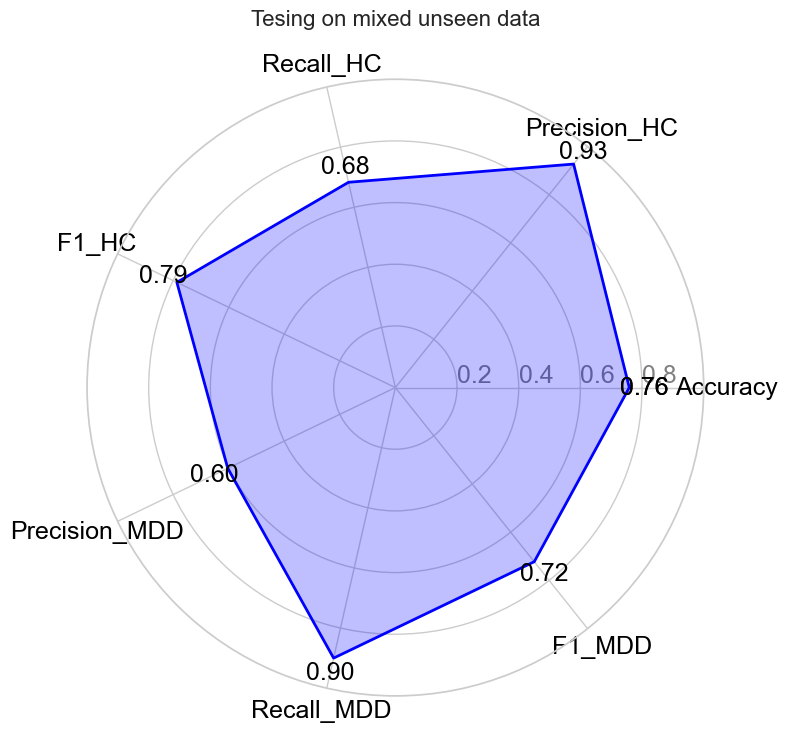

In [24]:
from math import pi

# === Radar Chart with Value Labels ===

# Prepare data
categories = [m[0] for m in metrics_order]
values = [m[1] for m in metrics_order]
values_rounded = [round(v, 3) for v in values]  # For display
values += values[:1]  # repeat to close the circle
values_rounded += values_rounded[:1]

# Radar chart setup
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='black', size=18)

# Draw line and fill
ax.plot(angles, values, linewidth=2, linestyle='solid', color='blue')
ax.fill(angles, values, color='blue', alpha=0.25)

# Annotate values
for angle, value, label in zip(angles, values, values_rounded):
    ax.text(angle, value + 0.05, f"{label:.2f}", color='black', ha='center', va='center', fontsize=18)

# Formatting
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=18)
plt.ylim(0, 1)
plt.title("Tesing on mixed unseen data", size=16, pad=20)
plt.tight_layout()
plt.show()


In [ ]:
from math import pi

# === Radar Chart with Value Labels ===

# Prepare data
categories = [m[0] for m in metrics_order]
values = [m[1] for m in metrics_order]
values_rounded = [round(v, 3) for v in values]  # For display
values += values[:1]  # repeat to close the circle
values_rounded += values_rounded[:1]

# Radar chart setup
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='black', size=18)

# Draw line and fill
ax.plot(angles, values, linewidth=2, linestyle='solid', color='blue')
ax.fill(angles, values, color='blue', alpha=0.25)

# Annotate values
for angle, value, label in zip(angles, values, values_rounded):
    ax.text(angle, value + 0.05, f"{label:.2f}", color='black', ha='center', va='center', fontsize=18)

# Formatting
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=18)
plt.ylim(0, 1)
plt.title("Tesing on mixed unseen data", size=16, pad=20)
plt.tight_layout()
plt.show()



=== LODO Evaluation: Testing on EDAIC ===


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activi


=== LODO Evaluation: Testing on RAVDESS ===


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activi


=== LODO Evaluation: Testing on MODMA ===


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activi


=== LODO Evaluation: Testing on CMDC ===


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activi


=== LODO Evaluation: Testing on EATD ===


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activi

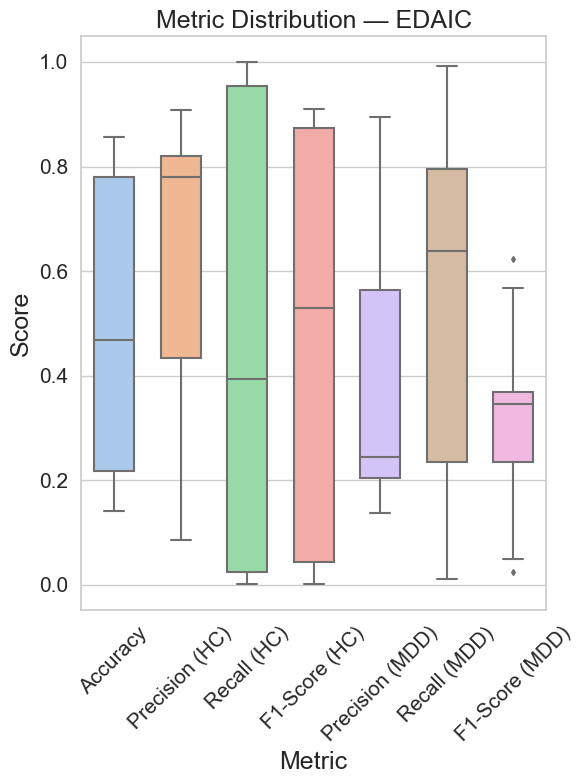

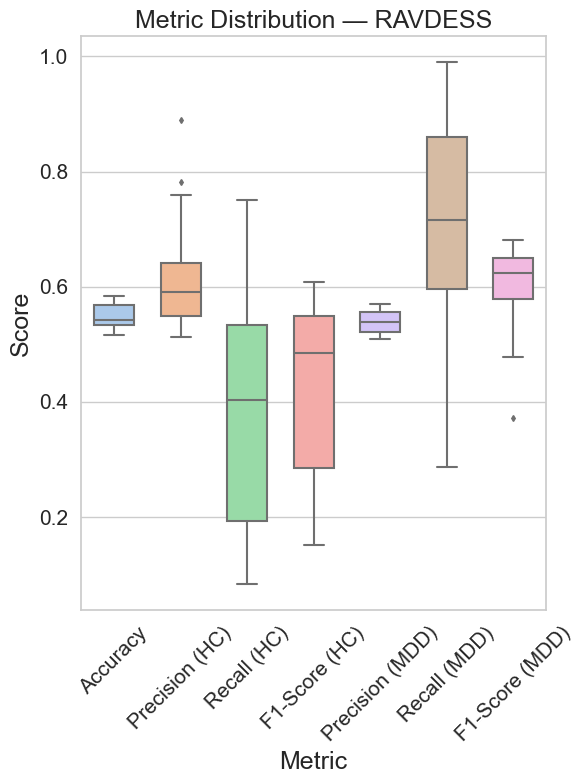

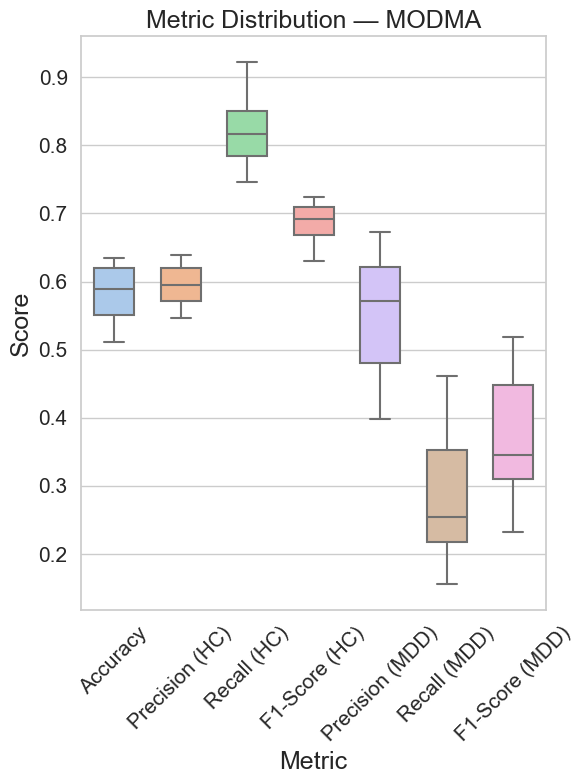

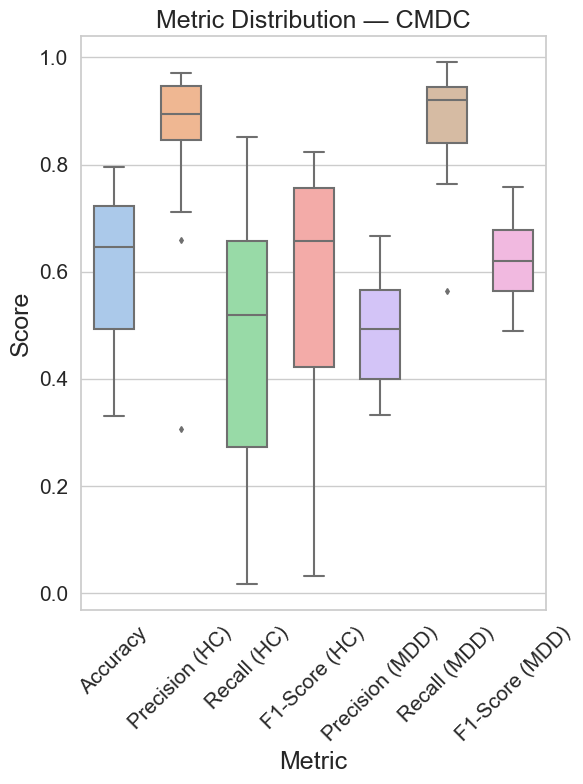

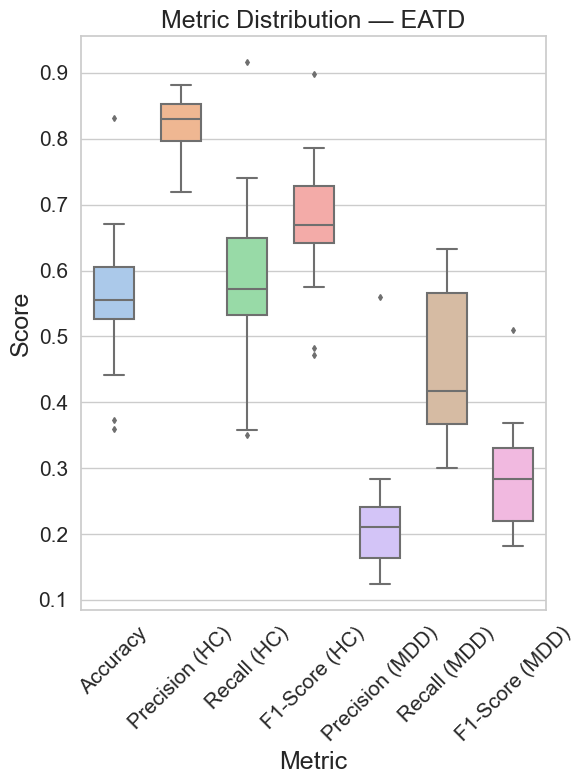

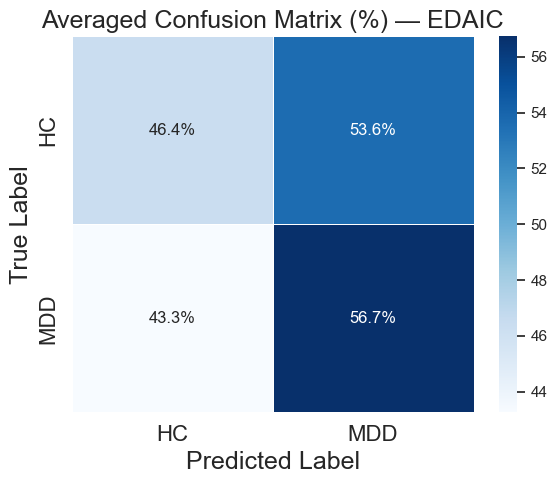

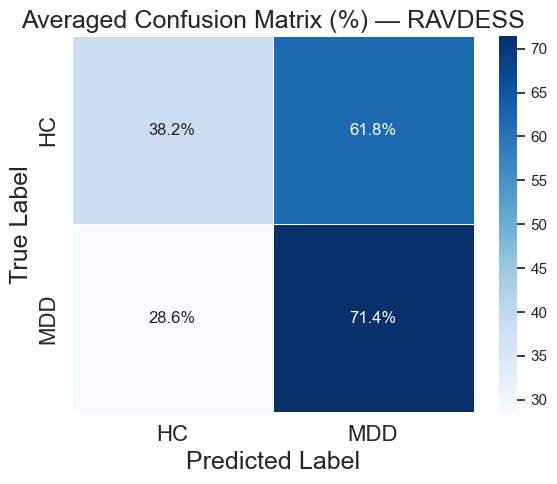

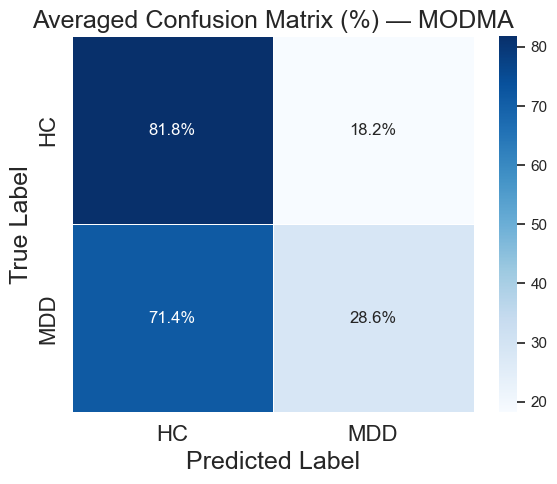

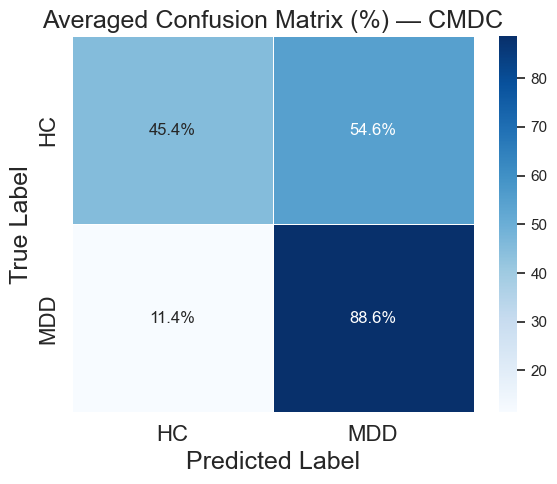

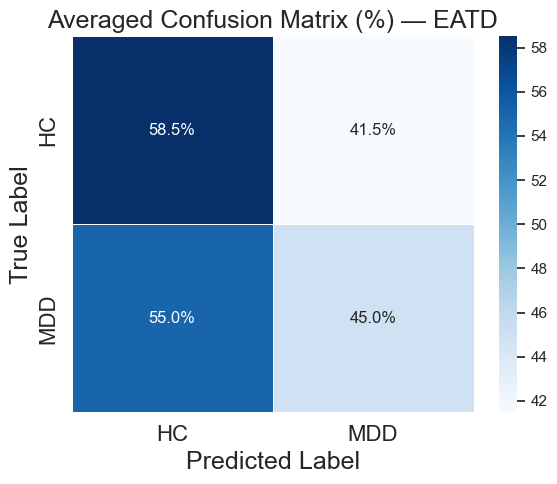

In [61]:
#LODO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

sns.set(style="whitegrid")

# === Base Path ===
base_path = "C:/Users/Administrator/PycharmProjects/Comprehensive/Cross_lang_ch8/DARNET/"

# === Load Domain Classifier and Scaler ===
domain_clf = joblib.load(base_path + "domain_classifier_logreg.pkl")
scaler_domain = joblib.load(base_path + "scaler_domain.pkl")

# === Dataset Configuration ===
all_domains = ["EDAIC", "RAVDESS", "MODMA", "CMDC", "EATD"]
english_domains = ["EDAIC", "RAVDESS"]
chinese_domains = ["MODMA", "CMDC", "EATD"]

# === Load All Datasets ===
def load_dataset(name):
    if name in ["EDAIC", "MODMA"]:
        X = np.load(base_path + f"X_fused_{name.lower()}.npy")
    elif name == "EATD":
        X = np.load(base_path + f"Data_eatd/combined_embeddings_04sec_eatd.npy")
    else:
        X = np.load(base_path + f"X_fused_{name.lower()}.npy")
    y = np.load(base_path + f"Data_{name.lower()}/labels_04sec_{name.lower()}.npy")
    return X, y

datasets = {name: load_dataset(name) for name in all_domains}

# === Prepare containers ===
n_runs = 20
all_results = {}
all_conf_matrices = {}

# === LODO Evaluation ===
for test_domain in all_domains:
    print(f"\n=== LODO Evaluation: Testing on {test_domain} ===")
    
    eng_train = [d for d in english_domains if d != test_domain]
    ch_train = [d for d in chinese_domains if d != test_domain]

    if not eng_train or not ch_train:
        print(f"Skipping {test_domain} (insufficient training data in one language group).")
        continue

    X_eng = np.concatenate([datasets[d][0] for d in eng_train], axis=0)
    y_eng = np.concatenate([datasets[d][1] for d in eng_train], axis=0)

    X_ch = np.concatenate([datasets[d][0] for d in ch_train], axis=0)
    y_ch = np.concatenate([datasets[d][1] for d in ch_train], axis=0)

    X_test_raw, y_test = datasets[test_domain]

    results = {
        "Accuracy": [],
        "Precision_HC": [], "Recall_HC": [], "F1_HC": [],
        "Precision_MDD": [], "Recall_MDD": [], "F1_MDD": []
    }
    conf_matrices = []

    for run in range(n_runs):
        # === English Model ===
        X_train_en, X_val_en, y_train_en, y_val_en = train_test_split(X_eng, y_eng, test_size=0.1, stratify=y_eng)
        scaler_en = StandardScaler()
        X_train_en = scaler_en.fit_transform(X_train_en)
        X_val_en = scaler_en.transform(X_val_en)

        model_en = Sequential([
            Dense(512, activation='relu', input_shape=(X_train_en.shape[1],)),
            Dropout(0.3),
            Dense(256, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_en.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        model_en.fit(X_train_en, y_train_en, validation_data=(X_val_en, y_val_en), batch_size=64, epochs=10, verbose=0)

        # === Chinese Model ===
        X_train_ch, X_val_ch, y_train_ch, y_val_ch = train_test_split(X_ch, y_ch, test_size=0.1, stratify=y_ch)
        scaler_ch = StandardScaler()
        X_train_ch = scaler_ch.fit_transform(X_train_ch)
        X_val_ch = scaler_ch.transform(X_val_ch)

        model_ch = Sequential([
            Dense(512, activation='relu', input_shape=(X_train_ch.shape[1],)),
            Dropout(0.3),
            Dense(256, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model_ch.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        model_ch.fit(X_train_ch, y_train_ch, validation_data=(X_val_ch, y_val_ch), batch_size=64, epochs=10, verbose=0)

        # === Inference: Routed ===
        X_domain = scaler_domain.transform(X_test_raw)
        domain_preds = domain_clf.predict(X_domain)
        y_pred = np.zeros_like(y_test)

        if np.any(domain_preds == 1):
            X_ch_test = scaler_ch.transform(X_test_raw[domain_preds == 1])
            y_pred[domain_preds == 1] = (model_ch.predict(X_ch_test, verbose=0).flatten() > 0.5).astype(int)

        if np.any(domain_preds == 0):
            X_en_test = scaler_en.transform(X_test_raw[domain_preds == 0])
            y_pred[domain_preds == 0] = (model_en.predict(X_en_test, verbose=0).flatten() > 0.5).astype(int)

        # === Evaluation ===
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

        results["Accuracy"].append(acc)
        results["Precision_HC"].append(report["0"]["precision"])
        results["Recall_HC"].append(report["0"]["recall"])
        results["F1_HC"].append(report["0"]["f1-score"])
        results["Precision_MDD"].append(report["1"]["precision"])
        results["Recall_MDD"].append(report["1"]["recall"])
        results["F1_MDD"].append(report["1"]["f1-score"])
        conf_matrices.append(cm)

    # Save
    all_results[test_domain] = results
    all_conf_matrices[test_domain] = conf_matrices

    df = pd.DataFrame(results)
    df.to_csv(base_path + f"lodo_routed_{test_domain.lower()}_20runs.csv", index=False)

    cm_total = np.sum(conf_matrices, axis=0)
    cm_norm = cm_total.astype('float') / cm_total.sum(axis=1)[:, np.newaxis] * 100
    labels_cm = np.array([["{0:.1f}%".format(v) for v in row] for row in cm_norm])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=labels_cm, fmt="", cmap="Blues", linewidths=0.5,
                xticklabels=["HC", "MDD"], yticklabels=["HC", "MDD"])
    plt.xlabel("Predicted Label", fontsize=16)
    plt.ylabel("True Label", fontsize=16)
    plt.title(f"Averaged Confusion Matrix — {test_domain}", fontsize=16)
    plt.tight_layout()
    plt.savefig(base_path + f"conf_matrix_lodo_{test_domain.lower()}.png")
    plt.close()

# === After All Domains ===
metrics_order = [
    ("Accuracy", "Accuracy"),
    ("Precision_HC", "Precision (HC)"),
    ("Recall_HC", "Recall (HC)"),
    ("F1_HC", "F1-Score (HC)"),
    ("Precision_MDD", "Precision (MDD)"),
    ("Recall_MDD", "Recall (MDD)"),
    ("F1_MDD", "F1-Score (MDD)")
]

# === Boxplots ===
for ds_name, results in all_results.items():
    plt.figure(figsize=(6,8))
    data = []
    labels = []
    for metric_key, metric_label in metrics_order:
        data.extend(results[metric_key])
        labels.extend([metric_label] * len(results[metric_key]))

    df_plot = pd.DataFrame({
        "Metric": labels,
        "Value": data
    })

    sns.boxplot(
        x="Metric", y="Value", data=df_plot,
        palette="pastel", width=0.6, fliersize=3
    )
    plt.title(f"Metric Distribution — {ds_name}", fontsize=18)
    plt.ylabel("Score", fontsize=18)
    plt.xlabel("Metric", fontsize=18)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

# === Confusion Matrices Again ===
for ds_name, conf_matrices in all_conf_matrices.items():
    cm_total = np.sum(conf_matrices, axis=0)
    cm_normalized = cm_total.astype('float') / cm_total.sum(axis=1)[:, np.newaxis] * 100
    labels = np.array([["{0:.1f}%".format(value) for value in row] for row in cm_normalized])

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_normalized, annot=labels, fmt="", cmap="Blues",
        linewidths=0.5, linecolor="white",
        xticklabels=["HC", "MDD"], yticklabels=["HC", "MDD"],
        cbar=True
    )
    plt.xlabel("Predicted Label", fontsize=18)
    plt.ylabel("True Label", fontsize=18)
    plt.title(f"Averaged Confusion Matrix (%) — {ds_name}", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()


In [63]:
# === Final Full Classification Reports ===
for ds_name, results in all_results.items():
    print(f"\n📋 Full Classification Report for {ds_name} (Averaged over {n_runs} runs)")
    df = pd.DataFrame(results)

    acc = df["Accuracy"].mean()
    pre_hc = df["Precision_HC"].mean()
    rec_hc = df["Recall_HC"].mean()
    f1_hc = df["F1_HC"].mean()
    pre_mdd = df["Precision_MDD"].mean()
    rec_mdd = df["Recall_MDD"].mean()
    f1_mdd = df["F1_MDD"].mean()

    # Macro averages
    macro_pre = (pre_hc + pre_mdd) / 2
    macro_rec = (rec_hc + rec_mdd) / 2
    macro_f1 = (f1_hc + f1_mdd) / 2

    # Weighted average (approximate using support ratios; adjust if true support is known)
    support_hc = 0.6  # adjust based on your dataset ratio if known
    support_mdd = 0.4
    weighted_pre = pre_hc * support_hc + pre_mdd * support_mdd
    weighted_rec = rec_hc * support_hc + rec_mdd * support_mdd
    weighted_f1 = f1_hc * support_hc + f1_mdd * support_mdd

    print(f"{'Class':<14}{'Precision':>10}{'Recall':>10}{'F1-Score':>10}")
    print("-" * 46)
    print(f"{'HC':<14}{pre_hc*100:10.2f}{rec_hc*100:10.2f}{f1_hc*100:10.2f}")
    print(f"{'MDD':<14}{pre_mdd*100:10.2f}{rec_mdd*100:10.2f}{f1_mdd*100:10.2f}")
    print(f"\n{'Accuracy':<14}{acc*100:10.2f}")
    print(f"{'Macro Avg':<14}{macro_pre*100:10.2f}{macro_rec*100:10.2f}{macro_f1*100:10.2f}")
    print(f"{'Weighted Avg':<14}{weighted_pre*100:10.2f}{weighted_rec*100:10.2f}{weighted_f1*100:10.2f}")



📋 Full Classification Report for EDAIC (Averaged over 20 runs)
Class          Precision    Recall  F1-Score
----------------------------------------------
HC                 60.33     46.40     46.61
MDD                39.53     56.74     32.13

Accuracy           48.70
Macro Avg          49.93     51.57     39.37
Weighted Avg       52.01     50.54     40.82

📋 Full Classification Report for RAVDESS (Averaged over 20 runs)
Class          Precision    Recall  F1-Score
----------------------------------------------
HC                 61.93     38.15     42.32
MDD                53.91     71.41     60.00

Accuracy           54.78
Macro Avg          57.92     54.78     51.16
Weighted Avg       58.72     51.45     49.39

📋 Full Classification Report for MODMA (Averaged over 20 runs)
Class          Precision    Recall  F1-Score
----------------------------------------------
HC                 59.38     81.78     68.73
MDD                55.13     28.63     37.27

Accuracy           58.37
Ma